In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from catboost import CatBoostClassifier
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OrdinalEncoder, RobustScaler, PolynomialFeatures)
from sklearn.svm import LinearSVC
from sqlalchemy import create_engine, text
from ydata_profiling import ProfileReport

## Подключение к базе данных и загрузка таблиц sql

In [ ]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [ ]:
engine = create_engine(connection_string)
del db_config
del connection_string

## Проведение первичного исследования таблиц

In [ ]:
query = '''
SELECT *
FROM collisions
LIMIT 10;
'''

pd.DataFrame(engine.connect().execute(text(query)))

In [ ]:
query = '''
SELECT *
FROM case_ids
LIMIT 10;
'''

pd.DataFrame(engine.connect().execute(text(query)))

In [ ]:
query = '''
SELECT *
FROM vehicles
LIMIT 10;
'''

pd.DataFrame(engine.connect().execute(text(query)))

In [ ]:
query = '''
SELECT *
FROM parties
LIMIT 10;
'''

pd.DataFrame(engine.connect().execute(text(query)))

### Выводы
1. Все таблицы имеют данные для выполнения поставленных задач
2. Таблиц достаточно для выполнения поставленных задач
3. Все таблицы имеют общий ключ для связи между собой

##  Проведение статистического анализа факторов ДТП

In [ ]:
query = '''
SELECT extract(month from collision_date) as month, count(*)
FROM collisions
GROUP BY month
ORDER BY month;
'''

collisions_per_month = pd.DataFrame(engine.connect().execute(text(query)))

In [ ]:
collisions_per_month

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(15, 5))
plt.bar(collisions_per_month['month'], collisions_per_month['count'])
plt.title('Количество ДТП по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество ДТП')
plt.show()

### Количество ДТП по месяцам
* С января по май включительно самое большое количество аварий, примерно в одном диапозоне.
* Март является самым аварийным месяцем.
* С июня по декабрь включительно количество аварий примерно одинаковое и меньше, чем в первой половине года.
* Самое маленькое количество аварий в июле.

### Список задач для статистического анализа
1. Проведите анализ серьёзности повреждений транспортного средства, исходя из тип кузова авто (связать collisions и vehicles)
2. Определите количество ДТП для разных видов коробок передач при разной погоде (связать collisions и vehicles)
3. Определите среднее количество участников ДТП для каждого из типов дорог (связать collisions и parties)
4. Определите, какая степень трезвости участника встречается чаще всего в каждом из районов (связать collisions и parties)
5. Определить зависимость между расстоянием от главной дороги и типом кузова авто (связать collisions и vehicles)

    5.1. Объедините таблицы collisions и vehicles

    5.2. Переведите расстояние в километры, округлите до целого числа

    5.3. Найдите самый популярный тип кузова авто для каждого 5го километра, например: 0-5, 5-10, 10-15 и т.д.

    5.4. Постройте график
    
    5.5. Сделайте вывод
    
6. Определите среднее количество участников ДТП для каждого из типов кузова авто (связать vehicles и parties)

    6.1. Объедините таблицы vehicles и parties

    6.2. Найдите среднее значение участников ДТП

    6.3. Сгрупируйте данные по типу кузова авто

    6.4. Постройте график
    
    6.5. Сделайте вывод

## Создание модели для оценки водительского риска

### Собираем требуемые данные из баззы данных

In [ ]:
query = '''
with fault as (
    SELECT case_id
    FROM parties
    where at_fault = 1
    and party_type = 'car'
), final_filter as (
    select case_id
    from collisions
    where collision_damage != 'scratch'
    and extract(year from collision_date) = 2012
    and case_id in (select * from fault)
)

select *
from vehicles
where case_id in (select case_id from final_filter);
'''

vehicles_df = pd.DataFrame(engine.connect().execute(text(query)))

In [ ]:
query = '''
with fault as (
    SELECT case_id
    FROM parties
    where at_fault = 1
    and party_type = 'car'
), final_filter as (
    select case_id
    from collisions
    where collision_damage != 'scratch'
    and extract(year from collision_date) = 2012
    and case_id in (select case_id from fault)
)

select *
from collisions
where case_id in (select case_id from final_filter);
'''

collisions_df = pd.DataFrame(engine.connect().execute(text(query)))

In [ ]:
query = '''
with fault as (
    SELECT case_id
    FROM parties
    where at_fault = 1
    and party_type = 'car'
), final_filter as (
    select case_id
    from collisions
    where collision_damage != 'scratch'
    and extract(year from collision_date) = 2012
    and case_id in (select * from fault)
)

select *
from parties
where case_id in (select case_id from final_filter);
'''

parties_df = pd.DataFrame(engine.connect().execute(text(query)))

### Подбираем данные для модели

In [ ]:
vehicles_df

In [ ]:
vehicles_df = vehicles_df[['case_id', # Требуется для объединения таблиц
                           'party_number', # Требуется для объединения таблиц
                           'vehicle_type', # Тип кузова влияет на характеристики автомобиля тем самым и на возможность аварии, ее последстия и другое
                           'vehicle_transmission', # Тип КПП влияет на воздействие человека на автомобиль тем самым и на возможность аварии
                           'vehicle_age']] # Возраст автомобиля влияет на его техническое состояние, что влияет на возможность аварии

In [ ]:
collisions_df

In [ ]:
collisions_df = collisions_df[['case_id', # Требуется для объединения таблиц
                               'county_city_location', # Разные города имеют разные дороги, что влияет на возможность аварии
                               'distance', # Расстояние от главной дороги может влиять на качество дороги, что влияет на возможность аварии
                               'direction', # Не известно как может направление движения влиять на возможность аварии, стоит проверить
                               'intersection', # Сложный перекресток может влиять на принятие решения человеком
                               'weather_1', # Погода создает определенные условия для вождения
                               'location_type', # Тип дороги влияет на скорость движения и восприятия пути человеком
                               'primary_collision_factor', # Неправильные действия при вождении увеличивают вероятность аварии
                               'pcf_violation_category', # Неправильные действия при вождении увеличивают вероятность аварии
                               'road_surface', # Дорожное покрытие влияет на поведение автомобиля
                               'road_condition_1', # Состояние дороги влияет на поведение автомобиля
                               'lighting', # Освещение влияет на видимость дороги и других автомобилей
                               'collision_date',# Возьмем месяц аварии. Мы узнали, что в первой половине года аварий больше
                               'collision_time']] # Возьмем час аварии для упрощения признака

In [ ]:
parties_df

In [ ]:
parties_df = parties_df[['case_id', # Требуется для объединения таблиц
                         'party_number', # Требуется для объединения таблиц
                         'at_fault', # Целевая переменная
                         'insurance_premium', # Стоимость страховки может влиять на качество вождения
                         'party_sobriety', # Состояние водителя влияет на качество вождения
                         'party_drug_physical', # Состояние водителя влияет на качество вождения
                         'cellphone_in_use']]   # Мобильное устройство может отвлекать водителя

### Формируем полную таблицу для модели и проводим анализ

In [ ]:
parties_vehicles_df = parties_df.merge(vehicles_df, on=['case_id', 'party_number'], how='left')
df = parties_vehicles_df.merge(collisions_df, on='case_id', how='left')
df.shape

In [ ]:
df

### Предобработка признаков

In [ ]:
cat_column = []
num_column = []

Данные для создания таблиц

In [ ]:
df.drop(['case_id', 'party_number'], axis=1, inplace=True)

at_fault

In [ ]:
df['at_fault'] = df['at_fault'].astype('bool')
cat_column.append('at_fault')

insurance_premium

In [ ]:
df['insurance_premium'] = df['insurance_premium'].fillna(0)
num_column.append('insurance_premium')

party_sobriety

In [ ]:
df['party_sobriety'] = df['party_sobriety'].fillna('had not been drinking')
cat_column.append('party_sobriety')

party_drug_physical

In [ ]:
df['party_drug_physical'] = df['party_drug_physical'].fillna('no drugs')
cat_column.append('party_drug_physical')

cellphone_in_use

In [ ]:
df['cellphone_in_use'] = df['cellphone_in_use'].fillna(0)
df['cellphone_in_use'] = df['cellphone_in_use'].astype('bool')
cat_column.append('cellphone_in_use')

vehicle_type

In [ ]:
df['vehicle_type'] = df['vehicle_type'].fillna('not applicable')
cat_column.append('vehicle_type')

vehicle_transmission

In [ ]:
df['vehicle_transmission'] = df['vehicle_transmission'].fillna('not applicable')
cat_column.append('vehicle_transmission')

vehicle_age

In [ ]:
df['vehicle_age'] = df['vehicle_age'].fillna(0)
num_column.append('vehicle_age')

county_city_location

In [ ]:
num_column.append('county_city_location')

distance

In [ ]:
num_column.append('distance')

direction

In [ ]:
df['direction'] = df['direction'].fillna('unknown')
cat_column.append('direction')

intersection

In [ ]:
df['intersection'] = df['intersection'].fillna(0)
df['intersection'] = df['intersection'].astype('bool')
cat_column.append('intersection')

weather_1

In [ ]:
df['weather_1'] = df['weather_1'].fillna('unknown')
cat_column.append('weather_1')

location_type

In [ ]:
df['location_type'] = df['location_type'].fillna('road')
cat_column.append('location_type')

primary_collision_factor

In [ ]:
cat_column.append('primary_collision_factor')

pcf_violation_category

In [ ]:
df['pcf_violation_category'] = df['pcf_violation_category'].fillna('unknown')
cat_column.append('pcf_violation_category')

road_surface

In [ ]:
df['road_surface'] = df['road_surface'].fillna('dry')
cat_column.append('road_surface')

road_condition_1

In [ ]:
df['road_condition_1'] = df['road_condition_1'].fillna('normal')
cat_column.append('road_condition_1')

lighting

In [ ]:
df['lighting'] = df['lighting'].fillna('daylight')
cat_column.append('lighting')

collision_date

In [ ]:
df['collision_date'] = pd.to_datetime(df['collision_date'])
df['month'] = df['collision_date'].dt.month
df.drop('collision_date', axis=1, inplace=True)
cat_column.append('month')

collision_time

In [ ]:
df['collision_time'] = df['collision_time'].fillna('00')
df['collision_time'] = df['collision_time'].apply(lambda x: str(x)[:2]).astype(int)
df['collision_time'] = df['collision_time'].astype('int')
cat_column.append('collision_time')

In [ ]:
len(num_column), len(cat_column)

### Анализ данных

In [ ]:
profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)

In [ ]:
profile

In [ ]:
profile.to_file('car_accidents_analysis.html')

In [ ]:
df.to_csv('df.csv', index=False)

### Выводы по анализу данных
1. at_fault имеет почти равное количество значений 0 и 1, что добавит точности при обучении модели
2. insurance_premium имеет правильное распределение с некоторыми скачками, возможно, это связано с маркетинговой деятельностью и прайс-листом. Все пропуски в данных были заполнены нулями, так как предположительно данные средства были не застрахованы.
3. party_sobriety и party_drug_physical имеют похожие распределения и в 80% данных зафиксированно отсутствие алкогольного, наркатического опьянения и других воздействий. Пропуски в данных заполнили отсутствием воздействий. Корреляция, также, похожа.
4. cellphone_in_use имеет в 99% случаев отрицательное значение.
5. vehicle_type, vehicle_transmission, vehicle_age основная масса данных была не зафиксированна так как не все участники аварии явлаются транспортным средством.
6. county_city_location вифим, что есть некоторые города, в которых аварий сильно больше чем в других.
7. distance четверь данных является пропущенными, что может быть связанно с тем, что авария произошла на основной дороге.
8. direction количество значений примерно похоже, но на дорогах с севера на юг аварий больше. Также, есть не зафиксированные данные, их около 20%.
9. intersection 80% аварий происходит не на перекрестке.
10. weather_1 основная масса аварий происходит в безоблачную погоду. Такая погода является распространенной в Калифорнии.
11. location_type основная масса данных пропущена и была заполнена значением 'road'.
12. primary_collision_factor 99% данных говорат о нарушении правил. Данные имеют очень высокую корреляцию и являются сильно не сбалансированными.
13. pcf_violation_category имеет нормальное распределение с сильным приобладанием нарушения правил скоростного режима.
15. road_surface 95% данных говорят о сухой дороге. Признак имеет высокую корреляцию и является сильно не сбалансированным.
16. road_condition_1 99% говорят о нормальной дороге.
17. lighting имеет нормальное распределение с сильным приобладанием дневного света.
18. collision_time нормальное распределение с двумя вершинами в 7-8 часов и 15-17 часов. Похоже на интервалы поездок на работу.
19. month в нашем наборе данных основная часть информации об аварих в первую половину года.

### Подготовка датасета к обучению модели

In [26]:
try:
    print('df is ready', df.shape)
except:
    df = pd.read_csv('df.csv')
    print('df is downloaded and ready', df.shape)

df is ready (198481, 21)


In [27]:
df.drop_duplicates(inplace=True)

In [28]:
train = df.drop('at_fault', axis=1)
target = df['at_fault'].astype('int')

In [29]:
cat_cols = train.select_dtypes(exclude='number').columns.tolist()
num_cols = train.select_dtypes(include='number').columns.tolist()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)

del train
del target

### Создание пайплана и обучение моделей

Задача стоит в разработке системы прогнозирования виновника аварии. Наша основная цель - минимизировать шанс аварии с виновником арендующим транспортное средство компании. Если мы можем предсказать аварию заблаговременно, это поможет нам сократить издержки.

В контексте нашего вопроса, recall может быть наиболее важной метрикой, так как нам важно идентифицировать и предотвратить аварии (истинно положительные случаи), а неправильно ее предсказать не так страшно (ложно положительные случаи).

In [31]:
num_pipeline = Pipeline(steps=[
    ('scale', RobustScaler()),
    ('drop_correlated_features', DropCorrelatedFeatures(threshold=0.8)),
    ('polynomial_features', PolynomialFeatures(degree=2)),
    ('drop_constant_features', DropConstantFeatures(tol=0.998))
])

cat_pipeline = Pipeline(steps=[
    ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)
], remainder='passthrough')

In [32]:
cbc = CatBoostClassifier(eval_metric='Recall')

# Определение Pipeline с шагами предобработки и моделью
pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', cbc)
])

# Определение параметров для подбора гиперпараметров
params = {
    'model__depth': [4, 5, 6, 7, 8, 10],
    'model__learning_rate': [0.01, 0.05, 0.075, 0.1, 0.15, 0.2],
    'model__l2_leaf_reg': [1, 2, 3, 4, 5, 7],
    'model__iterations': [100, 150, 200, 250, 300, 500],
    'model__border_count': [5, 10, 20, 30, 40],
    'model__thread_count': [2, 4, 6],
    'model__early_stopping_rounds': [10],
    'model__random_strength': [0.01, 0.1, 1, 1.5, 2],
    'model__max_ctr_complexity': [1, 2, 3, 4, 5]
}

# Создание RandomizedSearchCV
cbc_grid = RandomizedSearchCV(pipeline,
                          params,
                          n_iter=50,
                          cv=3,
                          verbose=5,
                          random_state=42,
                          scoring='recall',
                          n_jobs=-1)

# Подгонка модели
start = time.time()
cbc_grid.fit(X_train, y_train)
end = time.time()
cbc_time = end - start

# Вывод лучших параметров и результатов
print("Best Parameters:", cbc_grid.best_params_)
print("Best Recall Score:", cbc_grid.best_score_)
print("Time:", cbc_time)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


0:	learn: 0.4650781	total: 149ms	remaining: 37.2s
0:	learn: 0.4635553	total: 128ms	remaining: 31.9s
1:	learn: 0.4664100	total: 169ms	remaining: 20.9s
1:	learn: 0.4649601	total: 155ms	remaining: 19.2s
2:	learn: 0.4664100	total: 197ms	remaining: 16.2s
2:	learn: 0.4686457	total: 177ms	remaining: 14.5s
0:	learn: 0.4660366	total: 87ms	remaining: 21.7s
3:	learn: 0.5256714	total: 247ms	remaining: 15.2s
0:	learn: 0.5733912	total: 110ms	remaining: 10.9s
1:	learn: 0.4675692	total: 134ms	remaining: 16.6s
0:	learn: 0.4642023	total: 112ms	remaining: 11.1s
0:	learn: 0.5884435	total: 115ms	remaining: 11.4s
0:	learn: 0.4650331	total: 113ms	remaining: 11.2s
3:	learn: 0.5277235	total: 261ms	remaining: 16.1s
2:	learn: 0.4675692	total: 168ms	remaining: 13.9s
1:	learn: 0.5884435	total: 167ms	remaining: 8.18s
1:	learn: 0.5733912	total: 175ms	remaining: 8.57s
1:	learn: 0.4662191	total: 170ms	remaining: 8.31s
1:	learn: 0.4650781	total: 177ms	remaining: 8.67s
4:	learn: 0.5179353	total: 341ms	remaining: 16.7s
0

In [33]:
lr = LogisticRegression(tol=0.01)

pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', lr)
])

param_dist = {
    'model__C': np.logspace(-3, 3, 7),
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga']
}

lr_grid = RandomizedSearchCV(pipeline,
                          param_dist,
                          n_iter=50,
                          cv=3,
                          verbose=5,
                          random_state=42,
                          scoring='recall',
                          n_jobs=-1)

# Подгонка модели
start = time.time()
lr_grid.fit(X_train, y_train)
end = time.time()
lr_time = end - start

# Вывод лучших параметров и результатов
print("Best Parameters:", lr_grid.best_params_)
print("Best Recall Score:", lr_grid.best_score_)
print("Time:", lr_time)

/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 28 is smaller than n_iter=50. Running 28 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV 3/3] END model__C=0.001, model__penalty=l1, model__solver=liblinear;, score=0.657 total time=   1.2s
[CV 1/3] END model__C=0.001, model__penalty=l1, model__solver=liblinear;, score=0.674 total time=   1.5s
[CV 2/3] END model__C=0.001, model__penalty=l1, model__solver=liblinear;, score=0.676 total time=   1.6s
[CV 3/3] END model__C=0.001, model__penalty=l1, model__solver=saga;, score=0.528 total time=   1.4s
[CV 3/3] END model__C=0.001, model__penalty=l2, model__solver=liblinear;, score=0.886 total time=   1.6s
[CV 3/3] END model__C=0.001, model__penalty=l2, model__solver=saga;, score=0.325 total time=   0.9s
[CV 1/3] END model__C=0.01, model__penalty=l1, model__solver=liblinear;, score=0.646 total time=   1.6s
[CV 2/3] END model__C=0.001, model__penalty=l2, model__solver=liblinear;, score=0.803 total time=   3.0s
[CV 3/3] END model__C=0.01, model__penalty=l1, model__solver=liblinear;, score=0.647 total time=   1.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.01, model__penalty=l1, model__solver=saga;, score=0.516 total time=   0.9s
[CV 1/3] END model__C=0.001, model__penalty=l2, model__solver=liblinear;, score=0.695 total time=   4.2s
[CV 3/3] END model__C=0.01, model__penalty=l2, model__solver=liblinear;, score=0.712 total time=   1.4s
[CV 2/3] END model__C=0.01, model__penalty=l1, model__solver=liblinear;, score=0.649 total time=   5.3s
[CV 2/3] END model__C=0.01, model__penalty=l2, model__solver=liblinear;, score=0.732 total time=   2.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.01, model__penalty=l2, model__solver=liblinear;, score=0.714 total time=   4.0s
[CV 3/3] END model__C=0.01, model__penalty=l2, model__solver=saga;, score=0.548 total time=   1.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END model__C=0.001, model__penalty=l2, model__solver=saga;, score=0.853 total time=   8.9s
[CV 2/3] END model__C=0.001, model__penalty=l2, model__solver=saga;, score=0.921 total time=   8.6s
[CV 1/3] END model__C=0.001, model__penalty=l1, model__solver=saga;, score=0.849 total time=   9.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END model__C=0.001, model__penalty=l1, model__solver=saga;, score=0.919 total time=  10.0s
[CV 3/3] END model__C=0.1, model__penalty=l1, model__solver=liblinear;, score=0.640 total time=   1.2s
[CV 3/3] END model__C=0.1, model__penalty=l1, model__solver=saga;, score=0.551 total time=   1.3s
[CV 2/3] END model__C=0.1, model__penalty=l1, model__solver=liblinear;, score=0.657 total time=   3.5s
[CV 1/3] END model__C=0.01, model__penalty=l1, model__solver=saga;, score=0.852 total time=   9.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END model__C=0.01, model__penalty=l1, model__solver=saga;, score=0.919 total time=   9.6s
[CV 3/3] END model__C=0.1, model__penalty=l2, model__solver=liblinear;, score=0.902 total time=   1.3s
[CV 1/3] END model__C=0.1, model__penalty=l1, model__solver=liblinear;, score=0.650 total time=   5.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END model__C=0.01, model__penalty=l2, model__solver=saga;, score=0.857 total time=   8.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.1, model__penalty=l2, model__solver=liblinear;, score=0.687 total time=   3.9s
[CV 3/3] END model__C=0.1, model__penalty=l2, model__solver=saga;, score=0.553 total time=   1.4s
[CV 2/3] END model__C=0.1, model__penalty=l2, model__solver=liblinear;, score=0.733 total time=   3.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END model__C=0.01, model__penalty=l2, model__solver=saga;, score=0.920 total time=   8.5s
[CV 3/3] END model__C=1.0, model__penalty=l1, model__solver=saga;, score=0.554 total time=   1.3s
[CV 2/3] END model__C=1.0, model__penalty=l1, model__solver=liblinear;, score=0.652 total time=   2.5s
[CV 1/3] END model__C=1.0, model__penalty=l1, model__solver=liblinear;, score=0.651 total time=   3.0s
[CV 3/3] END model__C=1.0, model__penalty=l1, model__solver=liblinear;, score=0.645 total time=   3.0s
[CV 3/3] END model__C=1.0, model__penalty=l2, model__solver=liblinear;, score=0.727 total time=   1.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END model__C=0.1, model__penalty=l1, model__solver=saga;, score=0.857 total time=   9.5s
[CV 2/3] END model__C=0.1, model__penalty=l1, model__solver=saga;, score=0.918 total time=   9.6s
[CV 2/3] END model__C=1.0, model__penalty=l2, model__solver=liblinear;, score=0.735 total time=   2.7s
[CV 3/3] END model__C=1.0, model__penalty=l2, model__solver=saga;, score=0.456 total time=   0.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1.0, model__penalty=l2, model__solver=liblinear;, score=0.677 total time=   3.8s
[CV 1/3] END model__C=0.1, model__penalty=l2, model__solver=saga;, score=0.858 total time=   8.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END model__C=0.1, model__penalty=l2, model__solver=saga;, score=0.918 total time=   8.6s
[CV 3/3] END model__C=10.0, model__penalty=l1, model__solver=liblinear;, score=0.648 total time=   1.5s
[CV 1/3] END model__C=10.0, model__penalty=l1, model__solver=liblinear;, score=0.641 total time=   2.9s
[CV 3/3] END model__C=10.0, model__penalty=l1, model__solver=saga;, score=0.536 total time=   1.1s
[CV 2/3] END model__C=10.0, model__penalty=l1, model__solver=liblinear;, score=0.654 total time=   3.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END model__C=1.0, model__penalty=l1, model__solver=saga;, score=0.858 total time=   9.2s
[CV 3/3] END model__C=10.0, model__penalty=l2, model__solver=liblinear;, score=0.887 total time=   1.4s
[CV 2/3] END model__C=1.0, model__penalty=l1, model__solver=saga;, score=0.923 total time=   9.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=10.0, model__penalty=l2, model__solver=liblinear;, score=0.703 total time=   3.7s
[CV 3/3] END model__C=10.0, model__penalty=l2, model__solver=saga;, score=0.553 total time=   1.4s
[CV 2/3] END model__C=10.0, model__penalty=l2, model__solver=liblinear;, score=0.724 total time=   3.5s
[CV 1/3] END model__C=1.0, model__penalty=l2, model__solver=saga;, score=0.854 total time=   8.6s
[CV 2/3] END model__C=1.0, model__penalty=l2, model__solver=saga;, score=0.920 total time=   8.5s
[CV 2/3] END model__C=100.0, model__penalty=l1, model__solver=liblinear;, score=0.651 total time=   2.0s
[CV 1/3] END model__C=100.0, model__penalty=l1, model__solver=liblinear;, score=0.649 total time=   3.8s
[CV 3/3] END model__C=100.0, model__penalty=l1, model__solver=saga;, score=0.561 total time=   1.6s
[CV 3/3] END model__C=100.0, model__penalty=l1, model__solver=liblinear;, score=0.641 total time=   4.0s
[CV 3/3] END model__C=100.0, model__penalty=l2, model__solver=liblinear;, score=0.

/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END model__C=10.0, model__penalty=l1, model__solver=saga;, score=0.856 total time=   9.5s
[CV 2/3] END model__C=10.0, model__penalty=l1, model__solver=saga;, score=0.918 total time=   9.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=100.0, model__penalty=l2, model__solver=liblinear;, score=0.686 total time=   3.8s
[CV 2/3] END model__C=100.0, model__penalty=l2, model__solver=liblinear;, score=0.736 total time=   3.6s
[CV 3/3] END model__C=100.0, model__penalty=l2, model__solver=saga;, score=0.561 total time=   1.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END model__C=10.0, model__penalty=l2, model__solver=saga;, score=0.856 total time=   8.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END model__C=10.0, model__penalty=l2, model__solver=saga;, score=0.919 total time=   9.0s
[CV 3/3] END model__C=1000.0, model__penalty=l1, model__solver=liblinear;, score=0.635 total time=   2.1s
[CV 2/3] END model__C=1000.0, model__penalty=l1, model__solver=liblinear;, score=0.653 total time=   2.6s
[CV 3/3] END model__C=1000.0, model__penalty=l1, model__solver=saga;, score=0.495 total time=   0.9s
[CV 1/3] END model__C=1000.0, model__penalty=l1, model__solver=liblinear;, score=0.651 total time=   4.9s
[CV 3/3] END model__C=1000.0, model__penalty=l2, model__solver=liblinear;, score=0.887 total time=   1.4s
[CV 1/3] END model__C=100.0, model__penalty=l1, model__solver=saga;, score=0.858 total time=   9.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END model__C=100.0, model__penalty=l1, model__solver=saga;, score=0.922 total time=  10.1s
[CV 1/3] END model__C=1000.0, model__penalty=l2, model__solver=saga;, score=0.556 total time=   1.4s
[CV 3/3] END model__C=1000.0, model__penalty=l2, model__solver=saga;, score=0.566 total time=   1.4s
[CV 2/3] END model__C=1000.0, model__penalty=l2, model__solver=liblinear;, score=0.718 total time=   3.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__penalty=l2, model__solver=liblinear;, score=0.637 total time=   4.1s
[CV 1/3] END model__C=100.0, model__penalty=l2, model__solver=saga;, score=0.857 total time=   8.9s
[CV 2/3] END model__C=100.0, model__penalty=l2, model__solver=saga;, score=0.922 total time=   8.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__penalty=l1, model__solver=saga;, score=0.856 total time=   8.5s
[CV 2/3] END model__C=1000.0, model__penalty=l1, model__solver=saga;, score=0.919 total time=   8.3s
[CV 2/3] END model__C=1000.0, model__penalty=l2, model__solver=saga;, score=0.920 total time=   6.1s
Best Parameters: {'model__solver': 'liblinear', 'model__penalty': 'l2', 'model__C': 0.001}
Best Recall Score: 0.7945227611087281
Time: 45.3801908493042


In [34]:
rfc = RandomForestClassifier()

pipeline = Pipeline(steps=[
    ('pipeline', col_trans),
    ('model', rfc)
])

param_dist = {
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__max_depth': [None, 5, 10, 15, 20]
}

rfc_grid = RandomizedSearchCV(pipeline,
                    param_dist,
                    n_iter=30,
                    cv=5,
                    verbose=5,
                    random_state=42,
                    scoring='recall',
                    n_jobs=-1)

# Подгонка модели
start = time.time()
rfc_grid.fit(X_train, y_train)
end = time.time()
rfc_time = end - start

# Вывод лучших параметров и результатов
print("Best Parameters:", rfc_grid.best_params_)
print("Best Recall Score:", rfc_grid.best_score_)
print("Time:", rfc_time)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 25 is smaller than n_iter=30. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 3/5] END model__max_depth=None, model__n_estimators=100;, score=0.648 total time=  38.6s
[CV 1/5] END model__max_depth=None, model__n_estimators=100;, score=0.647 total time=  38.8s
[CV 5/5] END model__max_depth=None, model__n_estimators=100;, score=0.644 total time=  38.7s
[CV 4/5] END model__max_depth=None, model__n_estimators=100;, score=0.654 total time=  38.8s
[CV 2/5] END model__max_depth=None, model__n_estimators=100;, score=0.652 total time=  39.7s
[CV 5/5] END model__max_depth=None, model__n_estimators=200;, score=0.650 total time= 1.3min
[CV 1/5] END model__max_depth=None, model__n_estimators=200;, score=0.651 total time= 1.3min
[CV 3/5] END model__max_depth=None, model__n_estimators=200;, score=0.650 total time= 1.3min


/Users/vs/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 4/5] END model__max_depth=None, model__n_estimators=200;, score=0.655 total time= 1.3min
[CV 2/5] END model__max_depth=None, model__n_estimators=200;, score=0.658 total time= 1.3min
[CV 3/5] END model__max_depth=None, model__n_estimators=300;, score=0.647 total time= 2.0min
[CV 1/5] END model__max_depth=None, model__n_estimators=300;, score=0.652 total time= 2.0min
[CV 5/5] END model__max_depth=None, model__n_estimators=300;, score=0.652 total time= 2.0min
[CV 4/5] END model__max_depth=None, model__n_estimators=300;, score=0.655 total time= 2.0min
[CV 2/5] END model__max_depth=None, model__n_estimators=300;, score=0.662 total time= 2.0min
[CV 1/5] END model__max_depth=None, model__n_estimators=400;, score=0.652 total time= 2.6min
[CV 3/5] END model__max_depth=None, model__n_estimators=400;, score=0.652 total time= 2.6min
[CV 5/5] END model__max_depth=None, model__n_estimators=400;, score=0.647 total time= 2.6min
[CV 4/5] END model__max_depth=None, model__n_estimators=400;, score=0.

In [43]:
svc = LinearSVC()

# Определение Pipeline с шагами предобработки и моделью
pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', svc)
])

# Define the parameter distribution
param_dist = {
    'model__C': np.logspace(-3, 3, 7),
    'model__loss': ['hinge', 'squared_hinge'],
    'model__max_iter': np.arange(100, 1000, 100)
}

# Perform RandomizedSearchCV
svc_grid = RandomizedSearchCV(pipeline,
                          param_dist,
                          n_iter=50,
                          cv=3,
                          verbose=5,
                          random_state=42,
                          scoring='recall',
                          n_jobs=-1)

start = time.time()
svc_grid.fit(X_train, y_train)
end = time.time()
svc_time = end - start

# Вывод лучших параметров и результатов
print("Best Parameters:", svc_grid.best_params_)
print("Best Recall Score:", svc_grid.best_score_)
print("Time:", svc_time)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/s

[CV 1/3] END model__C=0.01, model__loss=hinge, model__max_iter=200;, score=0.529 total time=  10.2s
[CV 3/3] END model__C=0.01, model__loss=hinge, model__max_iter=200;, score=0.514 total time=  10.2s
[CV 2/3] END model__C=0.01, model__loss=hinge, model__max_iter=200;, score=0.500 total time=  10.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Lib

[CV 1/3] END model__C=10.0, model__loss=hinge, model__max_iter=200;, score=0.464 total time=  12.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=10.0, model__loss=hinge, model__max_iter=200;, score=0.201 total time=  12.9s
[CV 2/3] END model__C=10.0, model__loss=hinge, model__max_iter=200;, score=0.361 total time=  13.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=500;, score=0.816 total time=  30.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=500;, score=0.970 total time=  25.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=500;, score=0.418 total time=  31.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=100.0, model__loss=hinge, model__max_iter=500;, score=0.807 total time=  31.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=100.0, model__loss=hinge, model__max_iter=500;, score=0.357 total time=  30.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=100.0, model__loss=hinge, model__max_iter=500;, score=0.021 total time=  31.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=10.0, model__loss=hinge, model__max_iter=600;, score=0.877 total time=  36.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1000.0, model__loss=hinge, model__max_iter=900;, score=0.741 total time=  53.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1000.0, model__loss=hinge, model__max_iter=900;, score=0.111 total time=  54.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__loss=hinge, model__max_iter=900;, score=0.388 total time=  55.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=100;, score=0.547 total time=   6.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=100;, score=0.908 total time=   6.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=10.0, model__loss=hinge, model__max_iter=600;, score=0.984 total time=  29.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=10.0, model__loss=hinge, model__max_iter=600;, score=0.783 total time=  35.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=100;, score=0.800 total time=   6.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=500;, score=0.652 total time=  29.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=500;, score=0.632 total time=  30.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=500;, score=0.664 total time=  29.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.001, model__loss=hinge, model__max_iter=500;, score=0.551 total time=  18.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.001, model__loss=hinge, model__max_iter=500;, score=0.535 total time=  20.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.001, model__loss=hinge, model__max_iter=500;, score=0.526 total time=  25.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.1, model__loss=hinge, model__max_iter=900;, score=0.506 total time=  35.4s
[CV 1/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=900;, score=0.668 total time=  57.1s
[CV 3/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=900;, score=0.640 total time=  47.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Lib

[CV 3/3] END model__C=0.1, model__loss=hinge, model__max_iter=900;, score=0.549 total time=  35.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=100.0, model__loss=squared_hinge, model__max_iter=600;, score=0.452 total time=  30.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.1, model__loss=hinge, model__max_iter=100;, score=0.542 total time=   7.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.1, model__loss=hinge, model__max_iter=100;, score=0.630 total time=   5.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=900;, score=0.624 total time=  57.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 3/3] END model__C=0.1, model__loss=hinge, model__max_iter=100;, score=0.556 total time=   6.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.1, model__loss=hinge, model__max_iter=900;, score=0.557 total time=  48.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.01, model__loss=hinge, model__max_iter=100;, score=0.525 total time=   6.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=100.0, model__loss=squared_hinge, model__max_iter=600;, score=0.920 total time=  29.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.01, model__loss=hinge, model__max_iter=100;, score=0.472 total time=   6.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=100.0, model__loss=squared_hinge, model__max_iter=600;, score=0.310 total time=  29.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.01, model__loss=hinge, model__max_iter=100;, score=0.490 total time=   6.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=100.0, model__loss=hinge, model__max_iter=200;, score=0.162 total time=  10.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=100.0, model__loss=hinge, model__max_iter=200;, score=0.729 total time=  10.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=200;, score=0.645 total time=  10.6s
[CV 2/3] END model__C=100.0, model__loss=hinge, model__max_iter=200;, score=0.910 total time=  14.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=200;, score=0.652 total time=  10.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=100.0, model__loss=hinge, model__max_iter=800;, score=0.842 total time=  39.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=200;, score=0.647 total time=  10.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=10.0, model__loss=hinge, model__max_iter=700;, score=0.931 total time=  35.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=100.0, model__loss=hinge, model__max_iter=800;, score=0.307 total time=  40.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 1/3] END model__C=1.0, model__loss=hinge, model__max_iter=200;, score=0.286 total time=  11.3s
[CV 2/3] END model__C=1.0, model__loss=hinge, model__max_iter=200;, score=0.922 total time=  11.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=100.0, model__loss=hinge, model__max_iter=800;, score=0.795 total time=  40.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=100;, score=0.855 total time=   5.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1.0, model__loss=hinge, model__max_iter=200;, score=0.332 total time=  11.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=100;, score=0.540 total time=   5.8s
[CV 2/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=100;, score=0.527 total time=   6.0s
[CV 1/3] END model__C=10.0, model__loss=hinge, model__max_iter=700;, score=0.858 total time=  43.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/s

[CV 2/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=300;, score=0.646 total time=  16.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=300;, score=0.650 total time=  17.5s
[CV 3/3] END model__C=10.0, model__loss=hinge, model__max_iter=700;, score=0.837 total time=  51.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=300;, score=0.646 total time=  17.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.001, model__loss=hinge, model__max_iter=100;, score=0.539 total time=   5.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 2/3] END model__C=0.001, model__loss=hinge, model__max_iter=100;, score=0.534 total time=   5.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.001, model__loss=hinge, model__max_iter=100;, score=0.528 total time=   6.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1.0, model__loss=hinge, model__max_iter=300;, score=0.953 total time=  16.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=10.0, model__loss=hinge, model__max_iter=500;, score=0.874 total time=  28.6s
[CV 3/3] END model__C=10.0, model__loss=hinge, model__max_iter=500;, score=0.013 total time=  28.4s
[CV 2/3] END model__C=10.0, model__loss=hinge, model__max_iter=500;, score=0.960 total time=  28.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1.0, model__loss=hinge, model__max_iter=300;, score=0.596 total time=  17.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1.0, model__loss=hinge, model__max_iter=300;, score=0.404 total time=  17.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.01, model__loss=hinge, model__max_iter=900;, score=0.505 total time=  38.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.01, model__loss=hinge, model__max_iter=900;, score=0.517 total time=  38.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.01, model__loss=hinge, model__max_iter=900;, score=0.506 total time=  39.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.1, model__loss=hinge, model__max_iter=500;, score=0.542 total time=  31.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.1, model__loss=hinge, model__max_iter=500;, score=0.460 total time=  23.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.1, model__loss=hinge, model__max_iter=500;, score=0.454 total time=  23.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=400;, score=0.648 total time=  22.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__loss=hinge, model__max_iter=300;, score=0.817 total time=  17.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=400;, score=0.651 total time=  22.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=400;, score=0.647 total time=  23.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=100;, score=0.680 total time=   6.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=600;, score=0.469 total time=  33.8s
[CV 2/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=600;, score=0.656 total time=  33.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=600;, score=0.894 total time=  33.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=100;, score=0.652 total time=   6.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 3/3] END model__C=1000.0, model__loss=hinge, model__max_iter=300;, score=0.339 total time=  17.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 3/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=100;, score=0.617 total time=   6.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1000.0, model__loss=hinge, model__max_iter=300;, score=0.941 total time=  23.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=300;, score=0.580 total time=  18.5s
[CV 2/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=300;, score=0.719 total time=  18.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 3/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=300;, score=0.721 total time=  18.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__loss=hinge, model__max_iter=200;, score=0.148 total time=  19.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.01, model__loss=hinge, model__max_iter=700;, score=0.523 total time=  32.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.01, model__loss=hinge, model__max_iter=700;, score=0.526 total time=  32.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.01, model__loss=hinge, model__max_iter=700;, score=0.517 total time=  31.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1000.0, model__loss=hinge, model__max_iter=200;, score=0.847 total time=  11.6s
[CV 3/3] END model__C=1000.0, model__loss=hinge, model__max_iter=200;, score=0.971 total time=  11.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=800;, score=0.048 total time=  46.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=800;, score=0.259 total time=  45.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=800;, score=0.287 total time=  46.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.01, model__loss=hinge, model__max_iter=500;, score=0.525 total time=  23.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=700;, score=0.948 total time=  40.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=700;, score=0.162 total time=  44.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=700;, score=0.228 total time=  40.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=700;, score=0.649 total time=  41.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=700;, score=0.651 total time=  41.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=700;, score=0.648 total time=  41.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=100.0, model__loss=hinge, model__max_iter=700;, score=0.789 total time=  41.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=100.0, model__loss=hinge, model__max_iter=700;, score=0.899 total time=  41.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=100.0, model__loss=hinge, model__max_iter=700;, score=0.150 total time=  41.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.01, model__loss=hinge, model__max_iter=500;, score=0.514 total time=  22.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.01, model__loss=hinge, model__max_iter=500;, score=0.508 total time=  22.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.1, model__loss=hinge, model__max_iter=700;, score=0.527 total time=  32.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.1, model__loss=hinge, model__max_iter=700;, score=0.468 total time=  32.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 3/3] END model__C=0.1, model__loss=hinge, model__max_iter=700;, score=0.579 total time=  32.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=400;, score=0.639 total time=  24.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1.0, model__loss=hinge, model__max_iter=900;, score=0.363 total time=  49.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__loss=hinge, model__max_iter=800;, score=0.887 total time=  47.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1.0, model__loss=hinge, model__max_iter=900;, score=0.378 total time=  48.8s
[CV 3/3] END model__C=1.0, model__loss=hinge, model__max_iter=900;, score=0.567 total time=  48.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=300;, score=0.891 total time=  18.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1000.0, model__loss=hinge, model__max_iter=800;, score=0.969 total time=  47.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=400;, score=0.667 total time=  25.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=300;, score=0.815 total time=  18.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=400;, score=0.650 total time=  24.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=100;, score=0.650 total time=   6.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=100;, score=0.657 total time=   6.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1000.0, model__loss=hinge, model__max_iter=800;, score=0.137 total time=  47.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=100;, score=0.648 total time=   6.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=300;, score=0.916 total time=  19.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=200;, score=0.365 total time=  14.0s
[CV 2/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=200;, score=0.969 total time=  13.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=200;, score=0.887 total time=  14.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=100.0, model__loss=hinge, model__max_iter=600;, score=0.969 total time=  39.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 3/3] END model__C=100.0, model__loss=hinge, model__max_iter=600;, score=0.825 total time=  39.1s
[CV 2/3] END model__C=100.0, model__loss=hinge, model__max_iter=600;, score=0.710 total time=  39.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=700;, score=0.651 total time=  44.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=700;, score=0.656 total time=  44.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=200;, score=0.672 total time=  12.3s
[CV 3/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=700;, score=0.637 total time=  44.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.01, model__loss=hinge, model__max_iter=800;, score=0.526 total time=  37.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.01, model__loss=hinge, model__max_iter=800;, score=0.515 total time=  36.1s
[CV 3/3] END model__C=0.01, model__loss=hinge, model__max_iter=800;, score=0.505 total time=  36.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__loss=hinge, model__max_iter=600;, score=0.824 total time=  34.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=200;, score=0.655 total time=   9.8s
[CV 3/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=200;, score=0.625 total time=   9.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1000.0, model__loss=hinge, model__max_iter=600;, score=0.047 total time=  26.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1000.0, model__loss=hinge, model__max_iter=600;, score=0.257 total time=  26.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Best Parameters: {'model__max_iter': 600, 'model__loss': 'hinge', 'model__C': 10.0}
Best Recall Score: 0.8815273048680538
Time: 432.33383798599243


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [44]:
results = {'Model:': ['CatBoostClassifier', 
                      'LogisticRegression', 
                      'RandomForestClassifier',
                      'SVC'],
           'Best Parameters:': [cbc_grid.best_score_, 
                                lr_grid.best_score_, 
                                rfc_grid.best_score_,
                                svc_grid.best_score_],
            'Time (sec/fit):': [cbc_time/150, lr_time/84, rfc_time/125, svc_time/150]}
results = pd.DataFrame(results)
results

,Model:,Best Parameters:,Time (sec/fit):
0,CatBoostClassifier,0.674954,1.834545
1,LogisticRegression,0.794523,0.540240
2,RandomForestClassifier,0.673932,7.836477
3,SVC,0.881527,2.882226


### Вывод

Задача стоит в разработке системы прогнозирования виновника аварии. Наша основная цель - минимизировать шанс аварии с виновником арендующим транспортное средство компании. Если мы можем предсказать аварию заблаговременно, это поможет нам сократить издержки.

В контексте нашего вопроса, recall может быть наиболее важной метрикой, так как нам важно идентифицировать и предотвратить аварии (истинно положительные случаи), а неправильно ее предсказать не так страшно (ложно положительные случаи).

SVC модель показала себя лучше в обучении и средней в скорости обучения. Возьмем ее для дальнейшего тестирования.

## Проведение анализ важности факторов ДТП

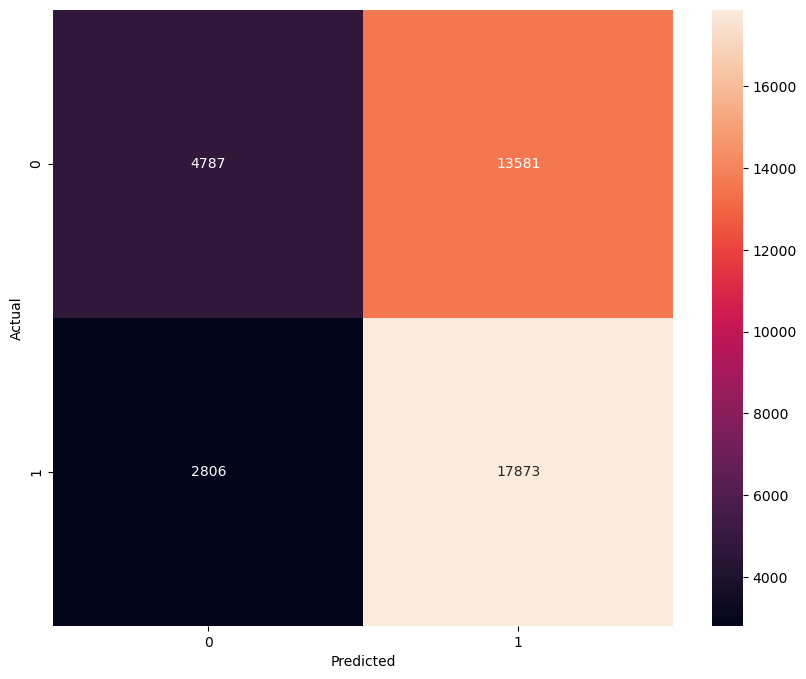

In [52]:
final_preds = svc_grid.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, final_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Выводы